In [19]:
# coding=utf-8
from matplotlib import pyplot as plt
import cv2
import numpy as np
import dlib
import time
import math
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.optimize import *

In [20]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
POINTS_NUM_LANDMARK = 68

## 1.dlib提取2D图片7个特征点

In [21]:
# 获取最大的人脸(get_landmark4函数内调用)
def largest_face(faces):
    '''
    求最大的人脸
    :param faces:detectors检测到的多个人脸的array
    :return:最大人脸的index
    '''
    if len(faces) == 1:
        return 0
    face_areas = [(face.right() - face.left()) * (face.bottom() - face.top()) for face in faces]  # 求脸的大小
    largest_area = face_areas[0]
    largest_index = 0
    for index in range(1, len(faces)):  # 取最大的脸
        if face_areas[index] > largest_area:
            largest_index = index
            largest_area = face_areas[index]
    print("largest_face index is {} in {} faces".format(largest_index, len(faces)))
    return largest_index

In [22]:
# 选取dlib检测的68点中的7个特征点
def get_points_2D(img):
    '''
    用dlib获取人脸4个特征点
    :param img: 输入图片
    :return: 人脸4特征点的矩阵shape=(4,2)，若未检测到人脸，返回None
    '''
    faces = detector(img, 0)  # 检测图片中的所有人脸,网上都是1，cvdlib中是0
    if len(faces) == 0:  # 没有检测到人脸
        print("ERROR: found no face")
        return None
    largest_index = largest_face(faces)  # 取最大人脸
    face_rectangle = faces[largest_index]  # 取对应人脸框
    landmark68 = predictor(img, face_rectangle)  # dlib检测人脸特征68点
    points_2D = np.array([  # 取出68点中所需的7个点
        (landmark68.part(36).x, landmark68.part(36).y),  # 左眼左眼角
        (landmark68.part(39).x, landmark68.part(39).y),  # 左眼右眼角
        (landmark68.part(42).x, landmark68.part(42).y),  # 右眼左眼角
        (landmark68.part(45).x, landmark68.part(45).y),  # 右眼右眼角
        (landmark68.part(30).x, landmark68.part(30).y),  # 鼻尖
        (landmark68.part(31).x, landmark68.part(31).y),  # 左鼻尖
        (landmark68.part(35).x, landmark68.part(35).y)  # 右鼻尖
    ], dtype="double")
    return points_2D

In [23]:
# 注释7个标记点
def annotate_points(img,point_2D):
    '''
    注释4个标记点
    :param im: 输入图片,4个标记点
    :return: 带有4个标记点的图片
    '''
    img_with_points = img.copy()
    for point in point_2D:
        point = (int(point[0]), int(point[1]))
        cv2.circle(img_with_points, point, 3, color=(0, 0, 255),thickness=-1)
    return img_with_points

## 2.手动构建4点人脸3D模型

In [24]:
# 手动构建4点人脸3D模型
def model_3D():
    '''
    手动构建4点人脸3D模型，以鼻尖为坐标原点
    :return: 3D模型4点矩阵 shape=(4,3)
    '''
    points_3D =np.array([
        (-225.0, -170.0, -135.0),  # 左眼左眼角
        (-75.0, -170.0, -135.0),  # 左眼右眼角，自己定的
        (75.0, -170.0, -135.0),  # 右眼左眼角，自己定的
        (225.0, -170.0, -135.0),  # 右眼右眼角
        (0.0, 0.0, 0.0),  # 鼻尖
        (-80.0, 10.0, -125.0),  # 左鼻尖
        (80.0, 10.0, -125.0)  # 右鼻尖
    ])
    return points_3D

## 3.归一化

In [25]:
# 归一化点
def get_normalize(points):
    '''
    归一化点
    :param 手动构建的3D模型(points_3D) 或 dlib检测到的4个特征点(points_2D)
    :return: 归一化后的点矩阵
    '''
    center = np.sum(points, axis=0) / points.shape[0]  # 中心
    L = np.sum(np.sum((points - center) ** 2, axis=1) ** 0.5)  # 归一化系数
    normalize = (points - center) / L
    return normalize, center, L

## 4.求投影矩阵P

In [26]:
# 求投影矩阵P
def get_P_matrix(normalize_3D, normalize_2D):
    num = normalize_2D.shape[0]
    _ = 0  # _是要舍弃的值
    if num < 3:
        return -1
    elif num == 3:
        _, r1_T = cv2.solve(normalize_3D.T, normalize_2D.T[0], _)
        _, r2_T = cv2.solve(normalize_3D.T,normalize_2D.T[1], _)
    else:
        _, r1_T = cv2.solve(normalize_3D, normalize_2D.T[0], _, cv2.DECOMP_SVD)  # 奇异值分解
        _, r2_T = cv2.solve(normalize_3D, normalize_2D.T[1], _, cv2.DECOMP_SVD)
    r1 = r1_T.T[0]
    r2 = r2_T.T[0]
    r3 = np.cross(r1, r2)
    P = np.array([r1, r2])
    return P

## 5.优化Delta

In [27]:
#传入4个点
def get_ball_center(normalize_3D_7):
    '''
    由4个点的坐标在球面上的关系式可转换成线性方程组的求解
    （x-xi)^2+(y-yi)^2+(z-zi)^2=r^2,最终可转化成AX=b的求解，A为3*3,b为3*1
    '''
    _=0
    
    normalize_3D=np.array([normalize_3D_7[0],normalize_3D_7[3],normalize_3D_7[4],(normalize_3D_7[5]+normalize_3D_7[6])/2.0])
    
    if normalize_3D.shape[0]!=4:
        return -1
    A=np.array([(normalize_3D[0]-normalize_3D[1]),(normalize_3D[3]-normalize_3D[3]),(normalize_3D[1]-normalize_3D[2])])
    tmp=np.array([np.sum(normalize_3D[0]**2),np.sum(normalize_3D[1]**2),np.sum(normalize_3D[2]**2),np.sum(normalize_3D[3]**2)])
    b=1/2*np.array([(tmp[0]-tmp[1]),(tmp[2]-tmp[3]),(tmp[1]-tmp[2])])
    _, X = cv2.solve(A, b, _, cv2.DECOMP_SVD)  # 奇异值分解
    ball_center=np.array([X[0][0],X[1][0],X[2][0]])
    return ball_center

In [28]:
#直角坐标系转球坐标系
def xyz_to_ball(normalize_3D,ball_center):
    normalize_3D_ball=np.zeros(normalize_3D.shape)  
    for i in range(normalize_3D.shape[0]):
        x=normalize_3D[i][0]-ball_center[0]
        y=normalize_3D[i][1]-ball_center[1]
        z=normalize_3D[i][2]-ball_center[2]
        
        r=(x**2+y**2+z**2)**0.5
        
        if x==0 :
            if y==0:
                theta=0
            else:
                theta=math.pi/2
        elif x<0 :#为了能表示出二三象限的角度
            theta=math.atan(y/x)+math.pi
        else:
            theta=math.atan(y/x)
        
        if r==0:
            fai=0
        else:
            fai=math.acos(z/r)
        normalize_3D_ball[i]=np.array([r,theta,fai])
    return normalize_3D_ball

In [29]:
# 变形后直角坐标系上的 3D 特征点 ball_delta_to_xyz
def ball_delta_to_xyz(normalize_3D_ball,Delta):
    normalize_3D_xyz_delta=np.zeros(normalize_3D_ball.shape)
    for i in range(normalize_3D_ball.shape[0]):
        r=normalize_3D_ball[i][0]
        theta=normalize_3D_ball[i][1]
        fai=normalize_3D_ball[i][2]
        delta_theta=Delta[i][0]
        delta_fai=Delta[i][1]
        x=r*math.sin(fai+delta_fai)*math.cos(theta+delta_theta)#+ball_center[0]
        y=r*math.sin(fai+delta_fai)*math.sin(theta+delta_theta)#+ball_center[1]
        z=r*math.cos(fai)#+ball_center[2]
        normalize_3D_xyz_delta[i]=np.array([x,y,z])
    return normalize_3D_xyz_delta

In [30]:
#Delta进行格式转换，将送入优化器的（14，）转换成（2，7）
def get_Delta_convert(Delta):
    return np.array([Delta[0:7],Delta[7:14]]).T

In [31]:
# 定义送入优化器的修正的目标函数
def f(Delta):
    #a=1
    Delta=get_Delta_convert(Delta)
    normalize_3D_xyz_delta=ball_delta_to_xyz(normalize_3D_ball,Delta)
    disparity = (normalize_2D - np.dot(normalize_3D_xyz_delta, P.T)).T # disparity:d=b-P*a
    objective = np.sum(disparity ** 2)  # 目标函数
    penalty =np.sum((normalize_3D_xyz_delta-normalize_3D)**2)# 惩罚函数
    revised_objective =  objective + a *penalty  # 修正的目标函数
    return revised_objective

## 6.计算Delta修正后的最优投影矩阵

In [32]:
# 得到Delta修正后的最优投影矩阵
def get_P_Delta_opt(normalize_2D, normalize_3D_xyz_delta_opt):
    '''
    计算Delta修正后的最优投影矩阵
    :param normalize_2D: 归一化2D特征点
    :param normalize_3D_xyz_delta_opt: Delta修正的3D模型
    :return:最优投影矩阵
    '''
    P_Delta_opt = np.dot(np.dot(normalize_2D.T, normalize_3D_xyz_delta_opt),\
                         np.linalg.pinv(np.dot(normalize_3D_xyz_delta_opt.T, normalize_3D_xyz_delta_opt)))
    return P_Delta_opt

## 7.计算欧拉角

In [33]:
# 由最优投影矩阵计算欧拉角
def get_euler_angle(P_Delta_opt):
    '''
    由最优投影矩阵计算欧拉角
    :param P_Delta_opt: 最优投影矩阵
    :return: 欧拉角
    '''
    pose = np.array([0.0, 0.0, 0.0])  # (theta x,y,z)
    r1 = P_Delta_opt[0]
    r2 = P_Delta_opt[1]
    r3 = np.cross(r1, r2)
    #print('r3=', r3)
    pose[0] = -math.atan(r3[1] / r3[2]) / math.pi * 180.0#论文和data的参考系不一致，前面加负号和data一致
    pose[1] = -math.atan(r3[0] / (r3[1] ** 2 + r3[2] ** 2) ** 0.5) / math.pi * 180.0
    pose[2] = -math.atan(r2[0] / r1[0]) / math.pi * 180.0 #论文和data的参考系不一致，前面加负号和data一致
    return pose

In [34]:
# 画表示姿势的线
def draw_line(img, points_2D,P_Delta_opt):
    '''
    画表示姿势的线
    :param img: 输入图片
    :param points_2D: dlib提取的2D特征点
    :return: 画有姿势线的图片
    '''
    nose_tip_2D = (int(points_2D[4][0]), int(points_2D[4][1]))
    far_3D = np.array([0.0, 0.0, 1000.0])
    far_2D = np.dot(np.dot(P_Delta_opt, (far_3D - center_3D) / L_3D), L_2D) + center_2D
    p1 = (int(nose_tip_2D[0]), int(nose_tip_2D[1]))
    p2 = (int(far_2D[0]), int(far_2D[1]))
    #print('p1=', p1, 'p2=', p2)
    img_with_line = np.copy(img)
    cv2.line(img_with_line, p1, p2, (0, 0, 255), 2)
    return img_with_line

In [35]:
#损失函数
def get_loss(pose,label):
    return np.sum(np.abs(pose-label))

## 主函数

         Current function value: 0.018980
         Iterations: 85
         Function evaluations: 4668
         Gradient evaluations: 291
Delta_opt=
 [[ 0.25685748  0.12496985]
 [ 0.53060908  0.35661326]
 [-0.53875367  0.35661323]
 [-0.25630916  0.12496945]
 [ 0.03396643 -0.30712675]
 [ 0.16422608 -0.55305762]
 [-0.14074489 -0.60950893]]

label= [-11.1298, 14.6895, -3.71618]

pose= [-12.79465823   8.81974847  -6.37757643]
loss= 10.1960061878

pose_opt= [-12.39789381   4.57870104  -6.61143187]
loss= 14.2741446421


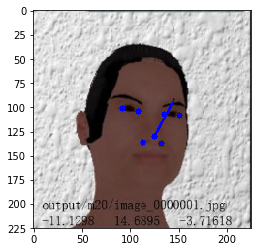

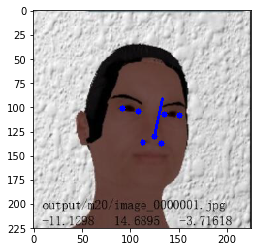

In [43]:
label_19=[-3.64614,-17.1319,-2.81734]
label_02=[-10.3737,-7.72744,2.86461]
label=[-11.1298,14.6895,-3.71618]
a=1
#读取图像
img0 = cv2.imread('20.jpg')
img0=cv2.resize(img0,(225,225))
img = img0[:,:,::-1] # 调节色彩通道

points_2D=get_points_2D(img)#检测2D特征点
points_3D=model_3D()#构造3D模型
img=annotate_points(img,points_2D)#注释标记点

normalize_3D,center_3D, L_3D=get_normalize(points_3D)#归一化
normalize_2D,center_2D, L_2D=get_normalize(points_2D)

P=get_P_matrix(normalize_3D,normalize_2D)#计算投影矩阵
pose=get_euler_angle(P)#计算未变形的姿势
img_with_line=draw_line(img,points_2D,P)#画姿势线

ball_center=get_ball_center(normalize_3D)#求4点球心
normalize_3D_ball=xyz_to_ball(normalize_3D,ball_center)

Delta=np.zeros((7,2))#初始化
Delta_opt=scipy.optimize.fmin_cg(f, Delta,gtol=1e-10)#共轭梯度下降法
Delta_opt=get_Delta_convert(Delta_opt)

normalize_3D_xyz_delta_opt=ball_delta_to_xyz(normalize_3D_ball,Delta_opt)

P_Delta_opt=get_P_Delta_opt(normalize_2D, normalize_3D_xyz_delta_opt)

pose_opt=get_euler_angle(P_Delta_opt)
img_with_line_opt=draw_line(img,points_2D,P_Delta_opt)

#print('normalize_2D=\n',normalize_2D)
#print('\nnormalize_3D=\n',normalize_3D)
#print("\nP=",P)
#print('\nDelta_opt=',Delta_opt)
#print('\nnormalize_3D_xyz_delta_opt=\n',normalize_3D_xyz_delta_opt)
#print('\nP_Delta_opt=\n',P_Delta_opt)
print('Delta_opt=\n',Delta_opt)
print('\nlabel=',label)
print('\npose=',pose)
print('loss=',get_loss(pose,label))
print('\npose_opt=',pose_opt)
print('loss=',get_loss(pose_opt,label))


plt.imshow(img_with_line)
plt.show()
plt.imshow(img_with_line_opt)
plt.show()